In [2]:
import pandas as pd
import numpy as np
import os
import librosa
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sn

from datetime import date
from IPython.display import display

import sagemaker 
import boto3
import s3fs
from io import StringIO, BytesIO

In [3]:
def get_file_keys(bucket, prefix, client=None):
    if client is None:
        client = boto3.client('s3')
    objs = client.list_objects(Bucket = bucket ,Prefix = prefix)
    keys = []
    for x in objs['Contents']:
        keys.append(x['Key'])
    return keys

In [4]:
def save_dataframe(df, filename, prefix = 'Demo/Predicted_Sounds_DataFrames'):
    csv_buffer = StringIO()
    df.to_csv(csv_buffer)
    s3_resource = boto3.resource('s3')
    s3_resource.Object('demo-bucket', prefix+'/'+filename).put(Body=csv_buffer.getvalue())

Import mortality data

In [6]:
s3 = boto3.resource('s3', region_name='us-east-1')
bucket = s3.Bucket('demo-bucket')
mort_key = 'input_data/Mortality_Data/cleaned_mortality_data.csv'
mort = pd.read_csv(bucket.Object(mort_key).get()['Body'], sep = ',', header=0, parse_dates=['Date'])

#rename columns
mort['Date'] = pd.to_datetime(mort['Date']).dt.date
mort['Outside High'] = mort['Outside.High.Low.Temp'].apply(lambda x: int(str(x).split('/')[0]))
mort['Outside Low'] = mort['Outside.High.Low.Temp'].apply(lambda x: int(str(x).split('/')[1]))
mort.drop(columns = 'Outside.High.Low.Temp', inplace=True)
mort.fillna(method = 'ffill')
display(mort.head())

#split into separate dataframes based on section
sec1 = mort[mort['Section']==1]
sec2 = mort[mort['Section']==2]
sec3 = mort[mort['Section']==3]
sec4 = mort[mort['Section']==4]

,Section,Date,Age,Water Consumption,Feed Consumption,Humidity Inside,Humidity Outside,Inside Low Temp,Inside High Temp,Total Mortality,Daily Headcount,Outside High,Outside Low
0,1,2021-08-01,10,511,2689.0,76,66,82.0,86.4,11,18892,85,70
1,1,2021-08-02,11,463,3042.0,75,72,81.3,86.3,14,18878,86,65
2,1,2021-08-03,12,625,3368.0,75,74,80.7,85.8,13,18865,85,64
3,1,2021-08-04,13,632,3412.0,77,73,80.2,85.2,6,18859,86,65
4,1,2021-08-05,14,678,3564.0,76,78,79.1,85.1,19,18840,83,66


Import predictions and create dataframe

In [7]:
pred_keys = get_file_keys('demo-bucket', 'results/analysis_data/predicted_labels/')[1:]
dfs = []
for key in pred_keys:
    df = pd.read_csv(bucket.Object(key).get()['Body'], sep = ',', index_col=0, header=0)
    dfs.append(df)

pred_df = pd.concat(dfs, axis = 0)
pred_df['Date'] = pd.to_datetime(pred_df['date']).dt.date
pred_df.drop(columns='date', inplace=True)
display(pred_df.head())
pred_df['total'] = pred_df['cluck'] + pred_df['trill'] + pred_df['squawk']+ pred_df['no_sound']
save_dataframe(pred_df, 'predicted_sounds_by_minute_Final.csv')

,no_sound,cluck,trill,squawk,Date
0,132631,443,0,1320,2021-08-09
1,127873,549,0,1175,2021-08-09
2,121447,302,0,648,2021-08-09
3,132049,1260,13,3475,2021-08-09
4,141519,40,0,40,2021-08-09


In [8]:
pred_df = pred_df.groupby('Date').sum().reset_index()
pred_df['Cluck Percent'] = pred_df['cluck']/pred_df['total']
pred_df['Trill Percent'] = pred_df['trill']/pred_df['total']
pred_df['Squawk Percent'] = pred_df['squawk']/pred_df['total']
print(pred_df.columns)
display(pred_df.head())

Index(['Date', 'no_sound', 'cluck', 'trill', 'squawk', 'total',
       'Cluck Percent', 'Trill Percent', 'Squawk Percent'],
      dtype='object')


,Date,no_sound,cluck,trill,squawk,total,Cluck Percent,Trill Percent,Squawk Percent
0,2021-08-09,3261238,12512,13,18947,3292710,0.003800,0.000004,0.005754
1,2021-08-10,3348743,21323,5,18612,3388683,0.006292,0.000001,0.005492
2,2021-08-11,3357179,17181,35,19127,3393522,0.005063,0.000010,0.005636
3,2021-08-12,3359950,18632,15,19732,3398329,0.005483,0.000004,0.005806
4,2021-08-13,3325616,21184,21,27457,3374278,0.006278,0.000006,0.008137


Function to save figure to S3

In [9]:
def s3_savefig(filename, prefix, bucket = 'demo-bucket'):
    buffer = BytesIO()
    plt.savefig(buffer)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, prefix+filename).put(Body=buffer.getvalue())

Function to plot DF series and save to S3

In [10]:
def create_df_plot(df, filename, primary_labels, secondary_labels=None):
    c_dict = {'Cluck Percent': 'purple', 'Squawk Percent': 'green',
              'Trill Percent': 'orange', 'Total Mortality': 'red',
              'Water Consumption': 'blue', 'Feed Consumption': 'brown'}
    fig, ax = plt.subplots(figsize = (12,8))
    df.plot(x='Date', y=primary_labels, ax=ax, marker='o',
           color=[c_dict[lab] for lab in primary_labels])
    ax.tick_params(labelrotation=-45)
    ax.legend(loc='upper left')
    ax.set_ylabel('Vocalization Percentage', fontsize=15)
    ax.set_xlabel('Date', fontsize=15)
    if secondary_labels is not None:
        ax2 = ax.twinx()
        df.plot(x='Date', y=secondary_labels, ax=ax2,
                c=c_dict[secondary_labels], alpha=0.5, marker='o')
        ax2.set_ylabel(secondary_labels, fontsize=15)
        ax2.legend(loc='upper right')
    fig.tight_layout()
    s3_savefig(filename, prefix='Demo/Viz/')
    plt.show()

Hampel filter to check for time series outliers

In [11]:
#https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d
def hampel_filter_pandas(input_series, window_size, n_sigmas=3):

    k = 1.4826 # scale factor for Gaussian distribution
    new_series = input_series.copy()

    # helper lambda function 
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    
    rolling_median = input_series.rolling(window=2*window_size, center=True).median()
    rolling_mad = k * input_series.rolling(window=2*window_size, center=True).apply(MAD)
    diff = np.abs(input_series - rolling_median)

    mask = (diff > (n_sigmas * rolling_mad))
    new_series[mask] = rolling_median[mask]
    
    return new_series, mask

Combine mortality and vocalization data and select variables. Create plot of vocalizations. Remove outliers.

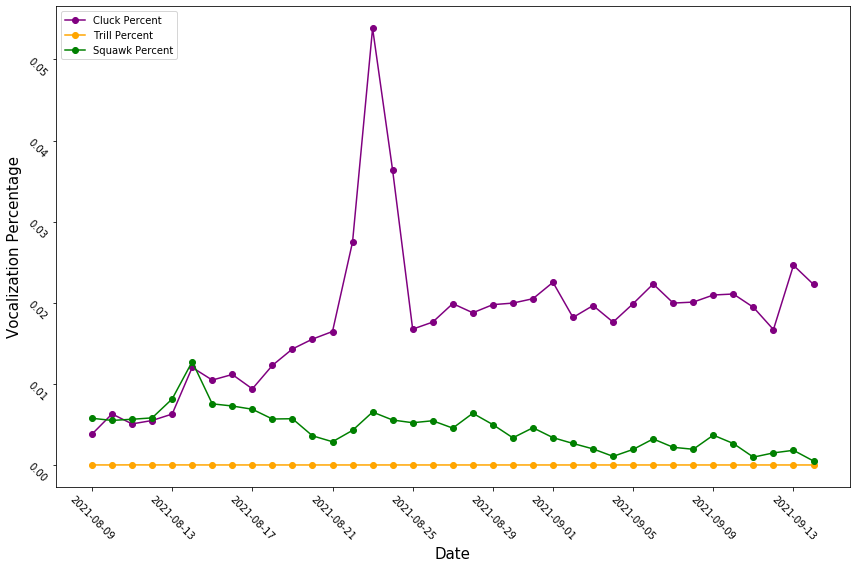

Outliers:
 14    2021-08-23
15    2021-08-24
Name: Date, dtype: object


In [12]:
#automatically difference the time series data until stationarity is achieved. Store the result in an dictionary
diffs = sec3.copy().merge(pred_df[['Date', 'Cluck Percent', 'Squawk Percent', 'Trill Percent']], on='Date')

diffs = diffs[['Date', 'Water Consumption', 'Feed Consumption', 
               'Humidity Inside', 'Inside High Temp', 'Total Mortality',
                'Squawk Percent', 'Trill Percent', 'Cluck Percent']]

create_df_plot(diffs, 'vocs_plot.png', ['Cluck Percent', 'Trill Percent', 'Squawk Percent'])
diffs['Cluck Percent'], cluck_mask = hampel_filter_pandas(diffs['Cluck Percent'], 4)
print('Outliers:\n', diffs['Date'][cluck_mask])

Create correlation coefficient heatmap and double axes plots

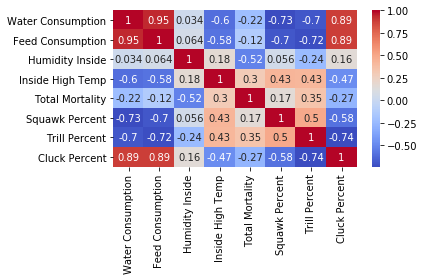

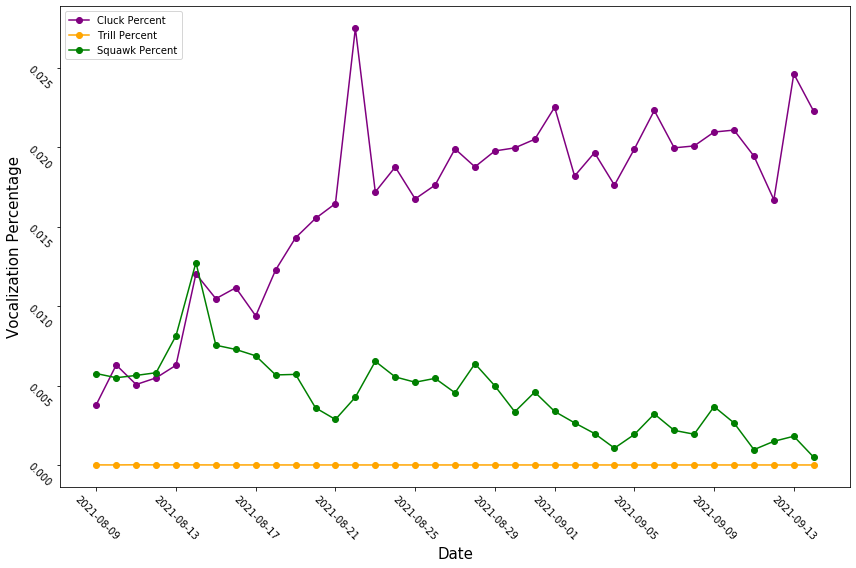

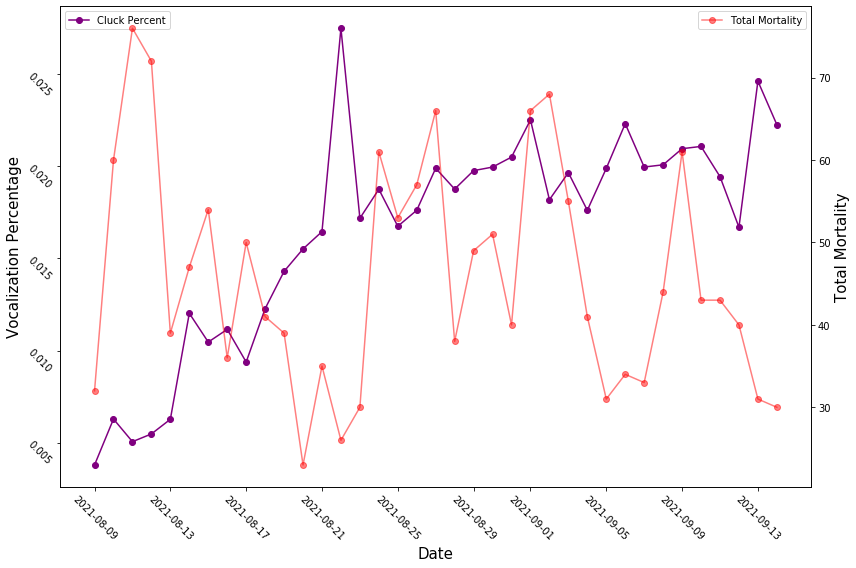

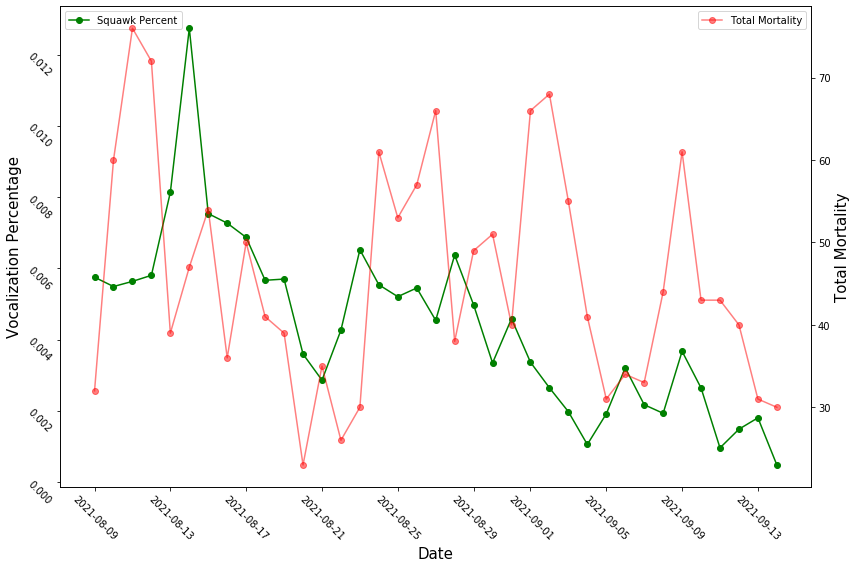

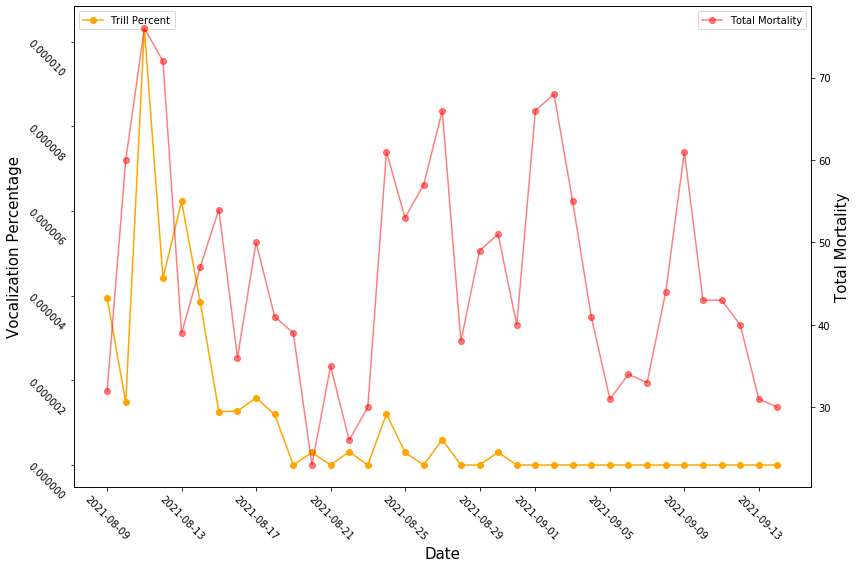

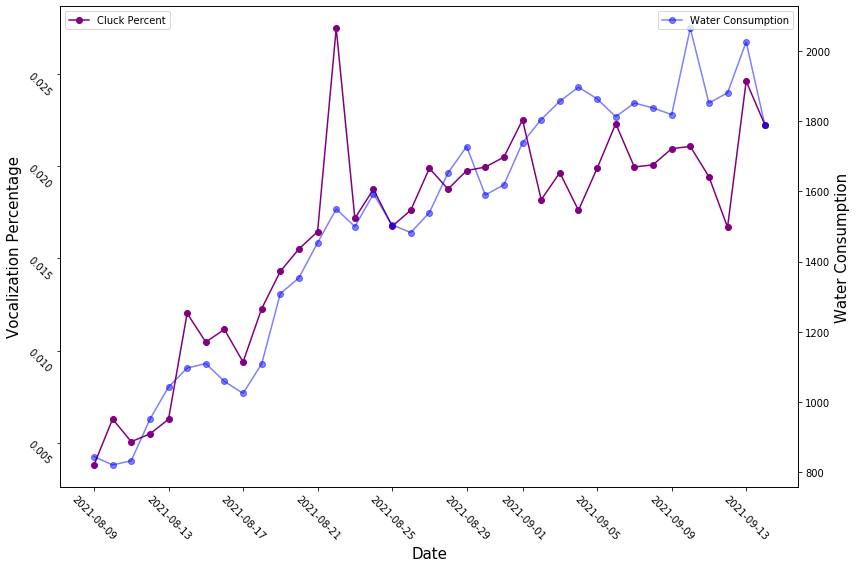

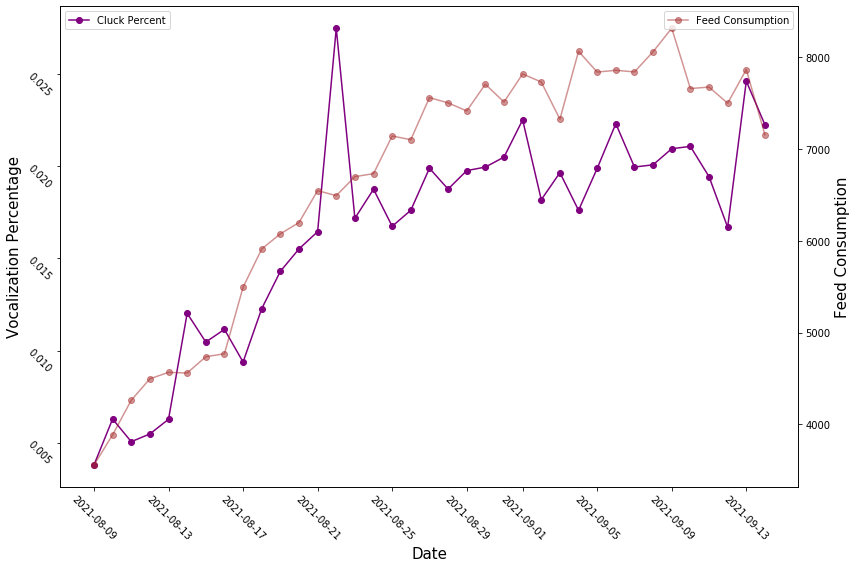

In [13]:
heat = sn.heatmap(diffs.corr(), cmap='coolwarm', annot=True)
plt.tight_layout()
s3_savefig('correlation_heatmap.png', prefix='Demo/Viz/')

create_df_plot(diffs, 'vocs_plot_no_out.png', 
               ['Cluck Percent', 'Trill Percent', 'Squawk Percent'])
create_df_plot(diffs, 'cluck_plot_mort.png', 
               ['Cluck Percent'], 'Total Mortality')
create_df_plot(diffs, 'squawk_plot_mort.png', 
               ['Squawk Percent'], 'Total Mortality')
create_df_plot(diffs, 'trill_plot_mort.png', 
               ['Trill Percent'], 'Total Mortality')
create_df_plot(diffs, 'cluck_plot_water.png', 
               ['Cluck Percent'], 'Water Consumption')
create_df_plot(diffs, 'cluck_plot_feed.png', 
               ['Cluck Percent'], 'Feed Consumption')

Create simple plots of selected variables

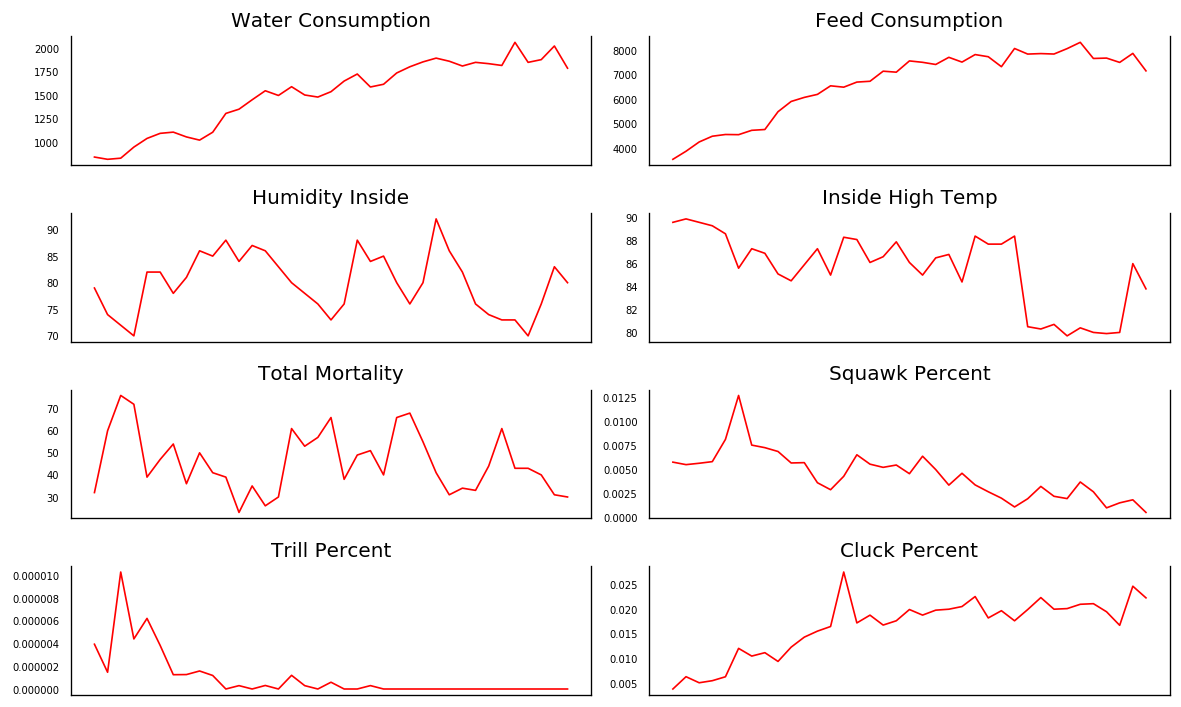

In [15]:
#https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = diffs[diffs.columns[i+1]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(diffs.columns[i+1])
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
s3_savefig('all_variable_plots.png', prefix='Demo/Viz/')


Augmented Dickey Fuller Test to check for stationarity

In [16]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [17]:
#VAR implementation from https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
        print('-'*50)
        print('\n')
        return True
    else:
        #print("Weak evidence against the null hypothesis")
        #print("Fail to reject the null hypothesis")
        #print("Data has a unit root and is non-stationary")
        print('\n')
        return False

Drop cluck percent and feed consumption and run ADF test for stationarity. Automatically differences each feature until stationarity is achieved and records the number of rounds of differencing used for each variable

In [18]:
diffs.drop(columns=['Cluck Percent', 'Feed Consumption'], inplace=True)
diff_dict = {}
for colname in diffs.columns:
    if colname != 'Date':
        counter=0
        while not adf_test(diffs[colname], title = f'{colname}: diffs={counter}') and counter <8:
            diffs[colname] = diffs[colname].diff()
            counter +=1 
        diff_dict[colname] = counter

        
max_diff = np.max(list(diff_dict.values()))
diffs = diffs[diffs['Date']>=date(2021,8,9+max_diff)]
diffs.set_index('Date', inplace=True)

Augmented Dickey-Fuller Test: Water Consumption: diffs=0
ADF test statistic      -2.017245
p-value                  0.279063
# lags used              4.000000
# observations          32.000000
critical value (1%)     -3.653520
critical value (5%)     -2.957219
critical value (10%)    -2.617588


Augmented Dickey-Fuller Test: Water Consumption: diffs=1
ADF test statistic      -4.424722
p-value                  0.000268
# lags used              3.000000
# observations          32.000000
critical value (1%)     -3.653520
critical value (5%)     -2.957219
critical value (10%)    -2.617588
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
--------------------------------------------------


Augmented Dickey-Fuller Test: Humidity Inside: diffs=0
ADF test statistic      -3.314390
p-value                  0.014247
# lags used              1.000000
# observations          35.000000
critical value (1%)     -3.632743
critical value (5%)

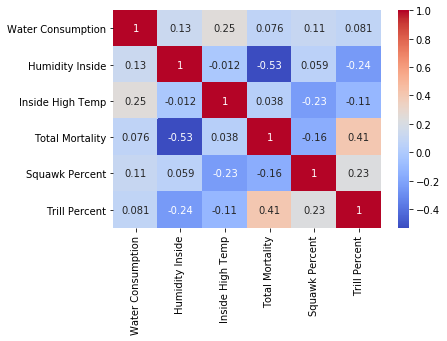

In [287]:
heat = sn.heatmap(diffs.corr(), cmap='coolwarm', annot=True)
s3_savefig('correlation_heatmap_differenced.png', prefix='Demo/Viz/')
plt.show()

Fit VAR models and print AIC and BIC

In [19]:
aics = []
bics = []
models = []
for i in range(4):
    model = VAR(diffs)
    results = model.fit(i)
    print('Order =', i)
    try:
        print('AIC: ', results.aic)
        print('BIC: ', results.bic)
        aics.append(results.aic)
        bics.append(results.bic)
        models.append(results)
    except:
        continue

Order = 0
AIC:  -20.141723038887935
BIC:  -19.877803215811916
Order = 1
AIC:  -19.729205203403303
BIC:  -17.862787529616007
Order = 2
AIC:  -21.723034489358966
BIC:  -18.221383874063065
Order = 3
AIC:  -21.59548111563168
BIC:  -16.42572772147475


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Find the best model

In [20]:
idx = np.argmin(aics)
best_model = models[idx]
print(best_model)

In [21]:
best_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 05, Dec, 2021
Time:                     23:42:26
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -18.2214
Nobs:                     34.0000    HQIC:                  -20.5289
Log likelihood:           157.828    FPE:                4.70362e-10
AIC:                     -21.7230    Det(Omega_mle):     6.74091e-11
--------------------------------------------------------------------
Results for equation Water Consumption
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                     -181.076413       436.425910           -0.415           0.678
L1.Water Consumption        -0.168775         0.249319           -0.677           0.498
L1.Humidity Inside  

Plot and save impulse responses

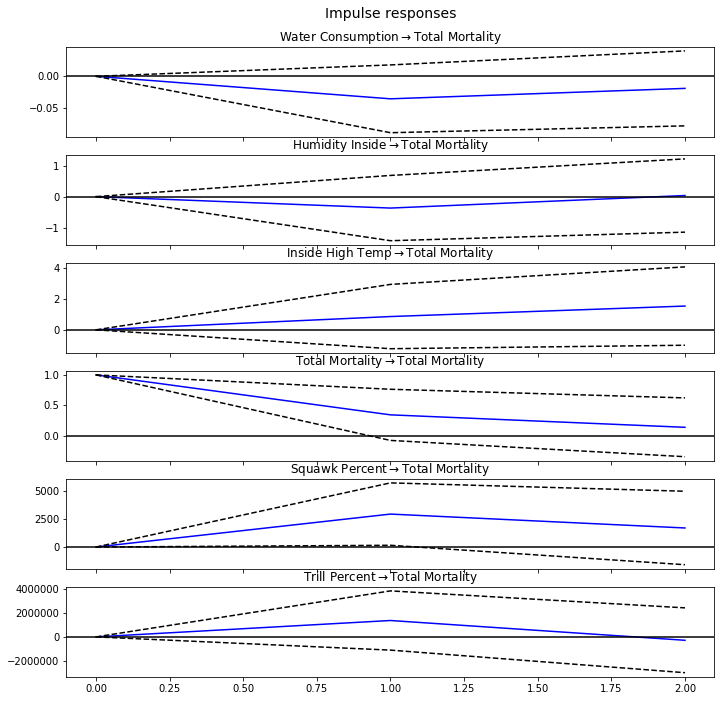

In [22]:
irf = best_model.irf(idx)
plot = irf.plot(orth=False, response='Total Mortality')
s3_savefig('impulse_response.png', prefix='Demo/Viz/')

Run Granger Causality tests for total mortality

In [349]:
for cause in diffs.columns:
    print(best_model.test_causality(caused='Total Mortality', causing=cause))
    print('\n')

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: Water Consumption does not Granger-cause Total Mortality: fail to reject at 5% significance level. Test statistic: 0.869, critical value: 3.068>, p-value: 0.422>


<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: Humidity Inside does not Granger-cause Total Mortality: fail to reject at 5% significance level. Test statistic: 0.454, critical value: 3.068>, p-value: 0.636>


<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: Inside High Temp does not Granger-cause Total Mortality: fail to reject at 5% significance level. Test statistic: 0.990, critical value: 3.068>, p-value: 0.375>


<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: Total Mortality does not Granger-cause Total Mortality: fail to reject at 5% significance level. Test statistic: 2.106, critical value: 3.068>, p-value: 0.126>


<statsmod

Plot forecasts

2


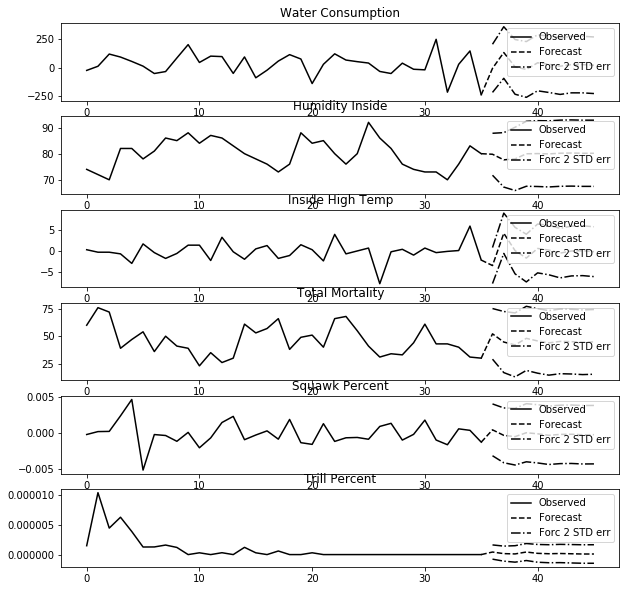

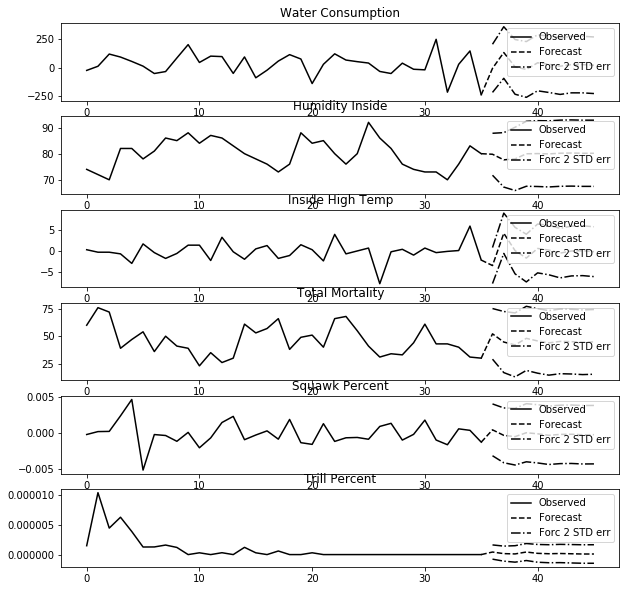

In [329]:
lag_order = best_model.k_ar
print(lag_order)
forecast = best_model.forecast(diffs.values[-lag_order:,:], 5)
best_model.plot_forecast(10)